In [1]:
import time
import numpy as np                        # for manipulating arrays
from specutils import Spectrum1D          # spectrum data model
import json                               # to pretty-print dicts
from astropy import units as u            # astropy utilities
from astropy.coordinates import SkyCoord
from astropy.table import Table
from matplotlib import pyplot as plt      # visualization libs
from IPython.display import display
%matplotlib inline
from getpass import getpass
from dl import authClient as ac, queryClient as qc #, storeClient as sc
from dl.helpers.utils import convert
from simulator import sim_event, sim_rubin_event

import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u


In [2]:
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()
if not ac.isValidToken(token):
    print('Error: invalid login for user %s (%s)' % (username,token))
else:
    print("Login token:   %s" % token)

Enter user name: (+ENTER)  varelanibal
Enter password: (+ENTER)  ········


Login token:   varelanibal.3772.3772.$1$ksendZlF$OwBWlJZ3Fbhx0tNC3WvkO/


In [17]:
import time
from tqdm.auto import tqdm

start_time = time.time()
ra_center = 266
dec_center = -29.0
radius = 0.1   # degrees
N = 10000
Ds_max = 8000
mu0_max = 5*np.log10(Ds_max)-5
print(mu0_max)
query = f"""
    SELECT *
    FROM lsst_sim.simdr2
    WHERE q3c_radial_query(ra, dec, {ra_center}, {dec_center}, {radius})
      AND mu0 < ({mu0_max})
    LIMIT {N+1000}
    """

res = qc.query(sql=query,format='csv')
df_raw_trilegal = convert(res,'pandas')
end_time = time.time()

from simulator import build_mu_rel_pairs
from ulens_params import event_param
df  = build_mu_rel_pairs(df_raw_trilegal, N, offset=0.1, min_D=1.0, random_state=None)
system_type = "BH"
result = {}
for i in tqdm(range(N)):
    
    TRILEGAL_data = {"D_S":df["D_S"].iloc[i],
                     "D_L":df["D_L"].iloc[i],
                     "mu_rel":df["mu_rel"].iloc[i],
                     "logL":df["logl"].iloc[i],
                     "logTe":df["logte"].iloc[i],
                     "ra":df["ra"].iloc[i],
                     "dec":df["dec"].iloc[i],
                     "u":df["umag"].iloc[i],
                     "g":df["gmag"].iloc[i],
                     "r":df["rmag"].iloc[i],
                     "i":df["imag"].iloc[i],
                     "z":df["zmag"].iloc[i],
                     "Y":df["ymag"].iloc[i]                
    }
    
    TRILEGAL_row = TRILEGAL_data
    # print(TRILEGAL_row)
    ulens_params = event_param(i, TRILEGAL_row, system_type)

    # for d in generador_diccionarios:  # tu for que genera los diccionarios
    for key, value in ulens_params.items():
        # si la llave no existe aún, la creo con una lista vacía
        result.setdefault(key, []).append(value)

    

14.515449934959719


  0%|          | 0/10000 [00:00<?, ?it/s]

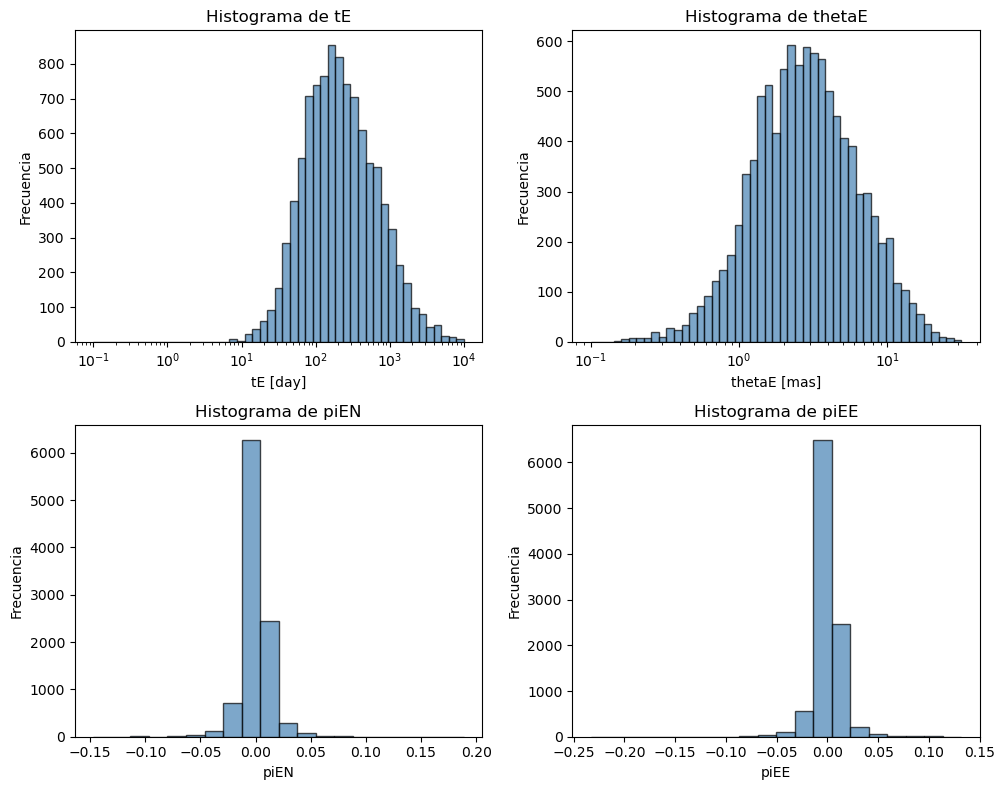

In [28]:
keys = ['tE', 'thetaE', 'piEN', 'piEE']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, key in zip(axes.flatten(), keys):
    if key=='tE':
        ax.hist(result[key], bins=np.logspace(-1,4,50), alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_title(f'Histograma de {key}')
        ax.set_xlabel(key+" [day]")
        ax.set_xscale("log")
        ax.set_ylabel('Frecuencia')
    elif key=='thetaE':
        ax.hist(result[key], bins=np.logspace(-1,1.5,50), alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_title(f'Histograma de {key}')
        ax.set_xlabel(key + " [mas]")
        ax.set_xscale("log")
        ax.set_ylabel('Frecuencia')
    else:
        ax.hist(result[key], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_title(f'Histograma de {key}')
        ax.set_xlabel(key)
        ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

check_event  : Everything looks fine...


/home/anibal/anaconda3/envs/roman_rubin/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/roman_rubin/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/roman_rubin/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 9 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/roman_rubin/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 9 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/roman_rubin/lib/python3.11/site-packages/erfa/core.py:133: ErfaW

Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS


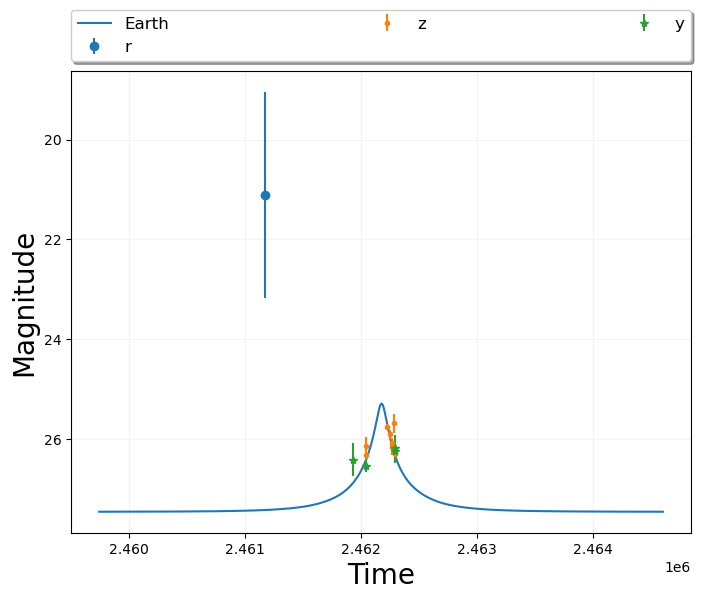

In [25]:
from simulator import model_rubin
from read_save import save_sim, read_data
from pyLIMA.outputs import pyLIMA_plots
import numpy as np
import matplotlib.pyplot as plt
info_dataset, pyLIMA_parameters, bands = read_data('/home/anibal/light_curve_rubin_test/Event_0.h5')
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
    'i':27.85, 'z':27.46, 'y':26.68}

ulens_params = []
PAR = ['t0','u0','tE','piEN','piEE']

for b in (PAR):
    ulens_params.append(pyLIMA_parameters[b])
flux_params = []

# Here we change the zero point to the pyLIMA convention in order to make the alignment
for b in bands:
    if not len(bands[b])==0:
        zp_Rubin_to_pyLIMA = (10**((-27.4+ZP[b])/2.5))
        # if not b=='W149':
        flux_params.append(pyLIMA_parameters['fsource_'+b]/zp_Rubin_to_pyLIMA)
        flux_params.append(pyLIMA_parameters['ftotal_'+b]/zp_Rubin_to_pyLIMA)
            
true_params = ulens_params+flux_params

model_ulens = 'PSPL'

Source = 0
event_params = pyLIMA_parameters
# event_params['te']=event_params['tE']
# event_params['s']=event_params['separation']
# event_params['q']=event_params['mass_ratio']

f = 'u'
lsst_u = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'g'
lsst_g = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'r'
lsst_r = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'i'
lsst_i = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'z'
lsst_z = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'y'
lsst_y = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T

model_true = model_rubin(Source,True,event_params,model_ulens,info_dataset[1], lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)

if len(true_params) != len(model_true.model_dictionnary):
    telescopes_fluxes = model_true.find_telescopes_fluxes(true_params)
    telescopes_fluxes = [getattr(telescopes_fluxes, key) for key in
                         telescopes_fluxes]#._fields]
    model_parameters3 = np.r_[true_params, telescopes_fluxes]
else:
    model_parameters3 = true_params

fig, axes = plt.subplots(1, 1,figsize=(8,6))

axes.set_ylabel("Magnitude",fontsize=20)
axes.set_xlabel("Time",fontsize=20)
axes.grid(True, color='0.95')
axes.invert_yaxis()

pyLIMA_plots.plot_photometric_models(axes, model_true, true_params, plot_unit='Mag')
pyLIMA_plots.plot_aligned_data(axes, model_true, true_params, plot_unit='Mag')
colors = ['darkslategray', 'gray', 'lightgray']

axes.legend(shadow=True, fontsize='large',
                          bbox_to_anchor=(0, 1.02, 1, 0.2),
                          loc="lower left",
                          mode="expand", borderaxespad=0, ncol=3)
plt.show()